In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dv003.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [4]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids='0006', xarray_dir='../data/NAFLD_test')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-11-7.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
cohort.eval_baseline()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD_test/0006/t1_pre_in.nc
Loading ../data/NAFLD_test/0006/t1_pre_water.nc
Loading ../data/NAFLD_test/0006/t1_pre_out.nc
Loading ../data/NAFLD_test/0006/t1_pre_fat.nc
Loading ../data/NAFLD_test/0006/t2.nc
Loading ../data/NAFLD_test/0006/mre_raw.nc
Loading ../data/NAFLD_test/0006/wave.nc
Loading ../data/NAFLD_test/0006/mre.nc
Loading ../data/NAFLD_test/0006/anat_mask.nc
Loading ../data/NAFLD_test/0006/mre_mask.nc
  0%|          | 0/1 [00:00<?, ?it/s]

  return key in self.data

  return key in self.data



100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


In [5]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [59]:
%autoreload

pino = mre_pinn.model.UNet(
    n_channels_in=4,
    n_channels_out=16,
    n_channels_block=16,
    n_unet_blocks=2,
    n_conv_per_block=1,
    width_factor=1,
    depth_factor=1,
    activ_fn='g',
    omega=80e-3,
    alpha=1e3,
    skip_connect=False
)
pino

UNet(
  (conv_in): Conv3d(4, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv_block_in): ConvBlock(
    (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (unet_block): UNetBlock(
    (downsample): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block_in): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (unet_block): UNetBlock(
      (downsample): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_block_in): ConvBlock(
        (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (conv_block_out): ConvBlock(
        (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (upsample): Upsample(scale_factor=2.0, mode=nearest)
    )
    (conv_block_out): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1

In [60]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-4,
    loss_weights=[1e0, 1e-1],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000610 s



Training model...

0         [9.23e+04, 1.69e+05]    [9.23e+04, 1.69e+05]    []  


<IPython.core.display.Javascript object>


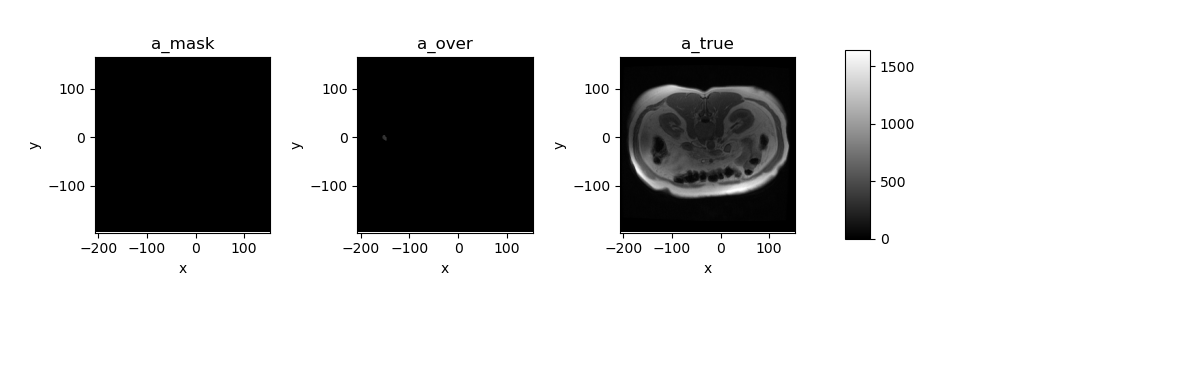

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


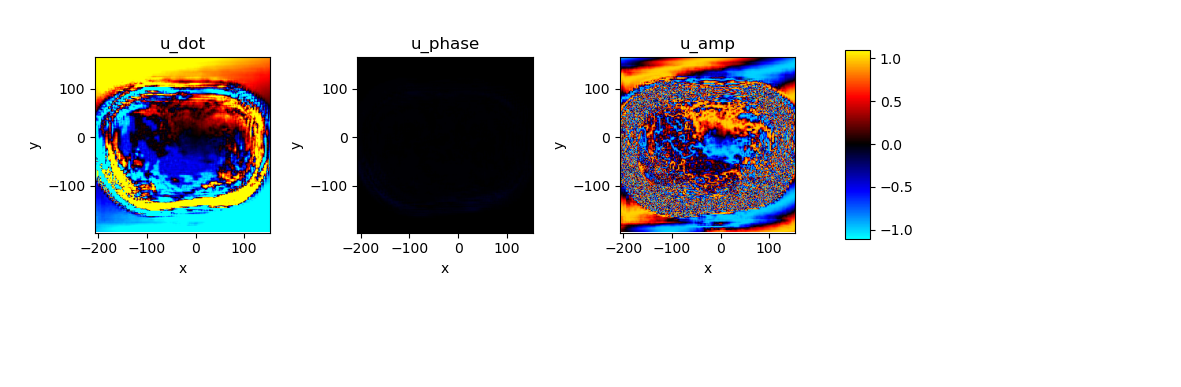

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


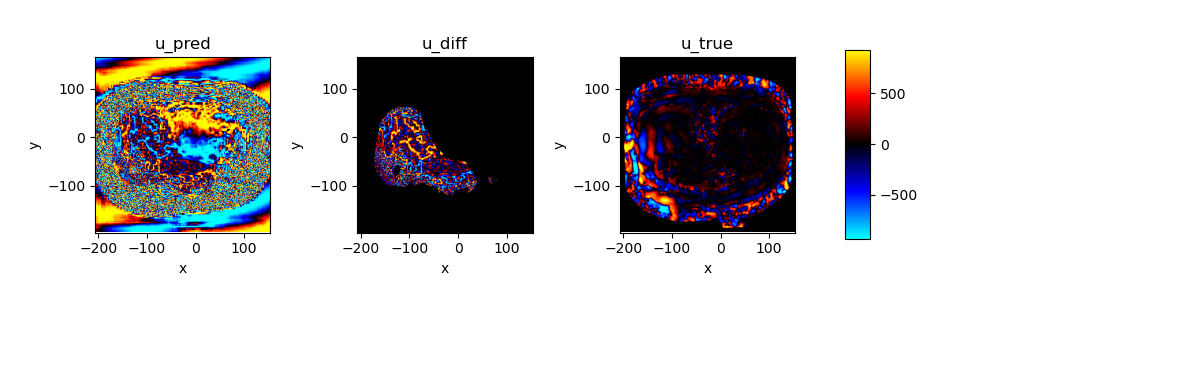

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


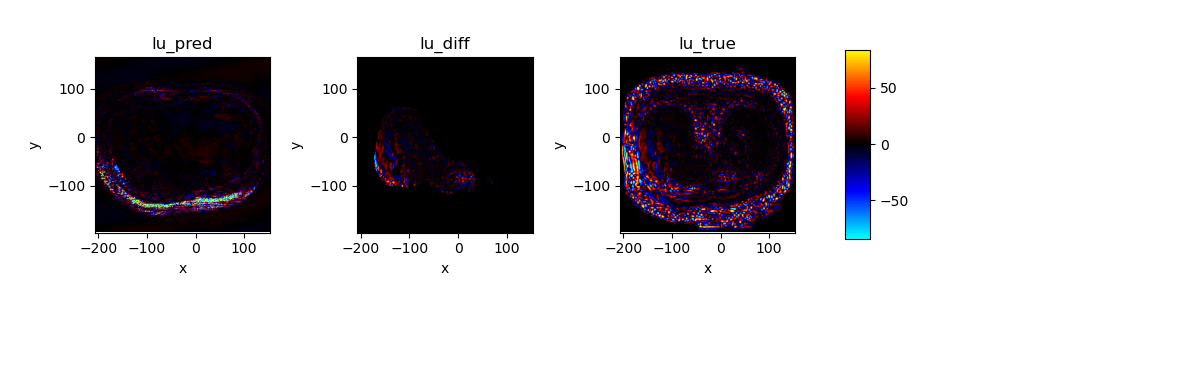

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

Time spent testing: 66.90%
10        [8.68e+04, 1.69e+05]    [8.68e+04, 1.69e+05]    []  
Time spent testing: 61.92%
20        [7.83e+04, 1.69e+05]    [7.83e+04, 1.69e+05]    []  
Time spent testing: 59.13%
30        [7.31e+04, 1.69e+05]    [7.31e+04, 1.69e+05]    []  
Time spent testing: 57.36%
40        [6.91e+04, 1.69e+05]    [6.91e+04, 1.69e+05]    []  
Time spent testing: 55.94%
50        [6.63e+04, 1.69e+05]    [6.63e+04, 1.69e+05]    []  
Time spent testing: 55.37%
60        [6.49e+04, 1.69e+05]    [6.49e+04, 1.69e+05]    []  
Time spent testing: 54.64%
70        [6.22e+04, 1.69e+05]    [6.22e+04, 1.69e+05]    []  
Time spent testing: 53.97%
80        [5.98e+04, 1.69e+05]    [5.98e+04, 1.69e+05]    []  
Time spent testing: 53.54%
90        [5.82e+04, 1.69e+05]    [5.82e+04, 1.69e+05]    []  
Time spent testing: 53.21%
100       [5.77e+04, 1.69e+05]    [5.77e+04, 1.69e+05]    []  
Time spent testing: 52.91%
110       [5.66e+04, 1.69e+05]    [5.66e+04, 1.69e+05]    []  
Time spent

In [ ]:
torch.backends.cudnn.enabled = False
model.train(10000, display_every=10, callbacks=[test_eval])

In [ ]:
torch.backends.cudnn.enabled = False
test_eval.model = model
test_eval.test()